In [1]:
## TRAINING

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class Vehicle_Classifier(object):
    img_width, img_height = 150, 150 # 64, 64  # 
    train_data_dir = 'train'
    validation_data_dir = 'validation'
    nb_train_samples = 1000
    nb_validation_samples = 35*3
    epochs = 200
    batch_size = 16

    train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical')

    if K.image_data_format() == 'channels_first':
        input_shape = (3, img_width, img_height)
    else:
        input_shape = (img_width, img_height, 3)

    def create_model(self):
        model = Sequential()
        model.add(Conv2D(32, (3, 3), input_shape=self.input_shape))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(32, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(64))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(3))
        model.add(Activation('softmax'))

        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
        return model    
    
    def train(self, model):
        i = 0
        while i < self.epochs:
            model.fit_generator(
                self.train_generator,
                steps_per_epoch=self.nb_train_samples // self.batch_size,
                epochs=10,
                validation_data=self.validation_generator,
                validation_steps=self.nb_validation_samples // self.batch_size)
            model.save_weights('weights_v3.h5')
            i += 10
            print('Step: %d' % i)
            
    def load_model(self, name):
        model = self.create_model()
        model.load_weights(name)
        return model


classifier = Vehicle_Classifier()
model = classifier.load_model('weights.h5')
# model = classifier.create_model()
# classifier.train(model=model)
# print(model.summary())

Using TensorFlow backend.


Found 967 images belonging to 3 classes.
Found 105 images belonging to 3 classes.


Found 17 images belonging to 1 classes.
2/2 [==============================] - 0s 235ms/step


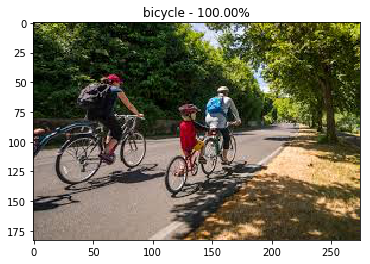

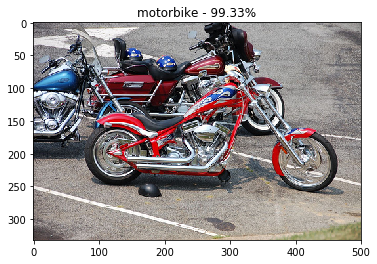

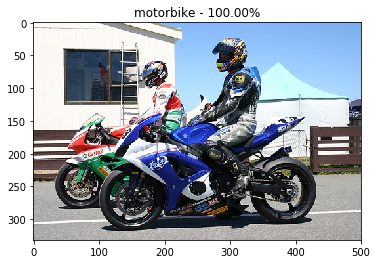

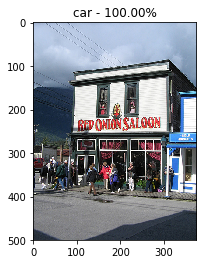

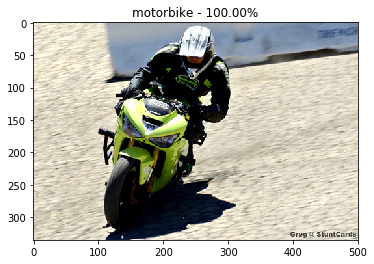

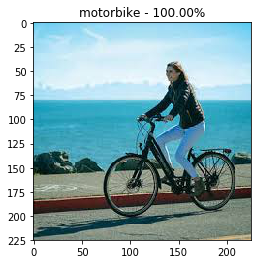

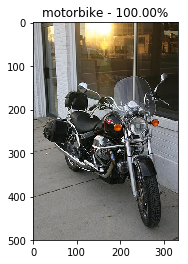

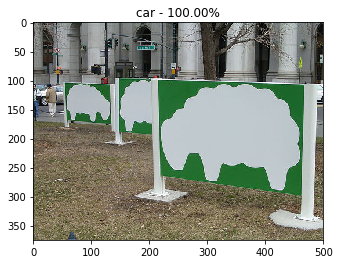

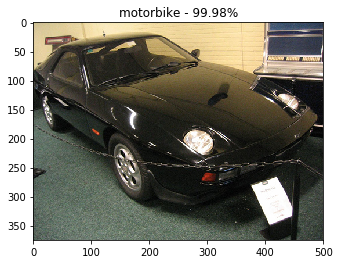

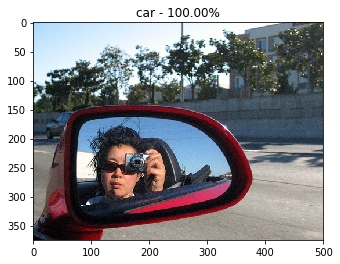

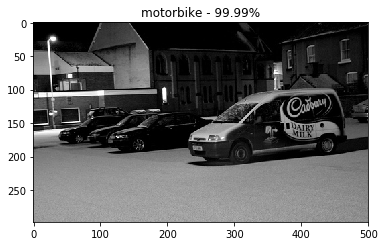

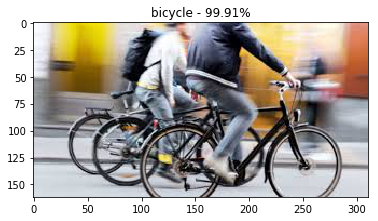

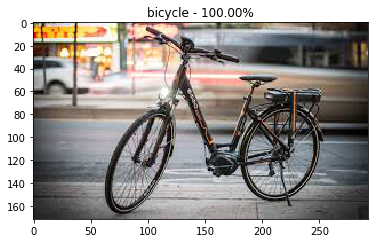

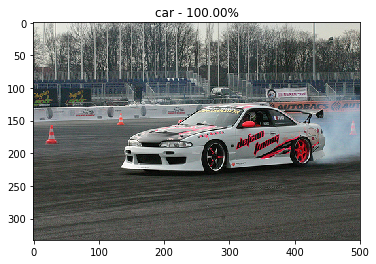

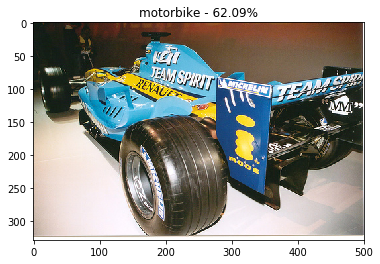

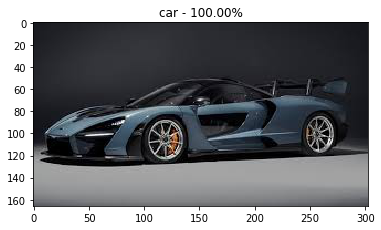

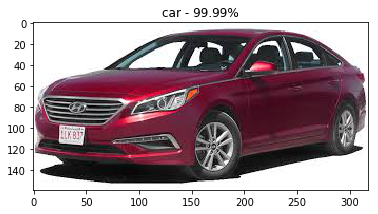

<Figure size 432x288 with 0 Axes>

In [2]:
## PREDICTING

def predict_folder(classifier, model, file_path):
    validation_generator = ImageDataGenerator(rescale=1. / 255).flow_from_directory(
        file_path,
        target_size=(classifier.img_height, classifier.img_width),
        batch_size=classifier.batch_size,
        shuffle=False,
        class_mode=None)

    pred = model.predict_generator(validation_generator,verbose=1)
    predicted_class_indices = np.argmax(pred,axis=1)
    
    probs = []
    i = 0
    for indice in predicted_class_indices:
        probs.append(pred[i][indice]/sum(pred[i]))
        i += 1

    labels = (classifier.train_generator.class_indices)
    labels = dict((v,k) for k,v in labels.items())

    predictions = [labels[k] for k in predicted_class_indices]
    filenames = validation_generator.filenames

    i = 0
    for _ in predictions:
        img = load_img('{}/{}'.format(file_path, filenames[i]))
        x = img_to_array(img)
        plt.imshow(x/255.)
        plt.title('%s - %.2f%%'%(predictions[i], probs[i]*100))
        plt.figure()
        i += 1

predict_folder(classifier, model, 'small_test')



Found 105 images belonging to 3 classes.
Classification Report
             precision    recall  f1-score   support

        car       0.81      0.60      0.69        35
    bicycle       0.86      0.71      0.78        35
  motorbike       0.58      0.83      0.68        35

avg / total       0.75      0.71      0.72       105

Confusion matrix, without normalization


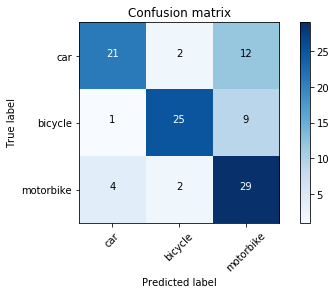

In [3]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


#Confution Matrix and Classification Report
validation_generator = ImageDataGenerator(rescale=1. / 255).flow_from_directory(
    classifier.validation_data_dir,
    target_size=(classifier.img_height, classifier.img_width),
    batch_size=classifier.batch_size,
    shuffle=False,
    class_mode='categorical')
Y_pred = model.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
array = confusion_matrix(classifier.validation_generator.classes, y_pred)
print('Classification Report')
target_names = classifier.train_generator.class_indices
print(classification_report(classifier.validation_generator.classes, y_pred, target_names=target_names))

df_cm = pd.DataFrame(array, index = target_names,
                  columns = target_names)
plot_confusion_matrix(array, target_names, title='Confusion matrix')